In [1]:
## Python package imports 
import numpy as np
import matplotlib
import os
import scipy.integrate as sint
import matplotlib.pyplot as plt

## Other toolboxes
import beam_analysis

## respic imports
import constants
import diagnostics
import fields
import particles
import solvers

## constants 
q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']
pi = np.pi


In [2]:
## Particle definitions and simulation setup
sigma_x = 0.2
sigma_xp = sigma_x /100.
Q_mks = 1.0e-9
Q = constants.charge_mks_to_cgs(Q_mks)
n_particles = 10000
ds = 1.0
s = 0
E = 200.0e6

## This is where we set the domain size 
L_0 = 20. * sigma_x ## Half the domain size
L_min = L_0 / 20 ## minimum wavelength to resolve

## This is where we initialize a gaussian distribuiton
distribution = particles.distribution(N = n_particles)
distribution.construct_uniform_guassian_2D(sigma_x = sigma_x, sigma_y = sigma_x,
                                          sigma_xp = sigma_xp, sigma_yp = sigma_xp)

## Particle distributions
# The first beam is the one that uses the drift map
my_gaussian_beam = particles.particles_2D_delta(distribution, bunch_charge = Q, 
            species_mass = m_p, K_e = E)

# This is for the matrix map
my_gaussian_beam_matrix = distribution

## Define the fields 
my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
    L_x_min = L_min, L_y_min = L_min)

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()
my_fields.register_solver(field_solver)

## Diagnostics 
respic_diag = diagnostics.bunch_statistics()
matrix_diag = diagnostics.bunch_statistics(divergence_coordinates = True)


In [3]:
## Load the maps
maps = solvers.symplectic_maps()

## Define steppers 
def step(fields, particles, ds = ds):
    maps.drift(particles, ds = ds / 2.)
    maps.space_charge_kick_2D(fields, particles, ds = ds)
    maps.drift(particles, ds = ds / 2.)

def step_matrix(particles, ds = ds):
    particles.x = particles.x + ds * particles.xp
    particles.y = particles.y + ds * particles.yp


In [4]:
## Here we run the simulation, 100 steps using the stepper functions defined in the previous block

respic_diag.update(s, my_gaussian_beam)
matrix_diag.update(s, my_gaussian_beam_matrix)

k = 0

while k < 100:

    step(my_fields, my_gaussian_beam)
    step_matrix(my_gaussian_beam_matrix)
    
    s = s + ds
    
    respic_diag.update(s, my_gaussian_beam)
    matrix_diag.update(s, my_gaussian_beam_matrix)
        
    k = k + 1

In [19]:
freq = 1.3e9
sigma_z = 1.0 # 10 cm sigma z -> 1 cm beam 
z_max = sigma_z / 10. 
Q_opal = Q_mks * z_max * 2 * 100
I_beam = Q_opal * freq

sigma_px = sigma_xp * my_gaussian_beam.pz / my_gaussian_beam.weight / my_gaussian_beam.m_0 / c
sigma_py = sigma_xp * my_gaussian_beam.pz / my_gaussian_beam.weight / my_gaussian_beam.m_0 / c



parameter_names = ['beam_gamma', 'beam_current_parameter', 'sigma_x', 'sigma_px', 'sigma_y', 'sigma_py', 'sigma_z']
parameter_values = [my_gaussian_beam.gamma, I_beam, sigma_x/100., sigma_px, sigma_x/100., sigma_py, sigma_z]

beam_analysis.generate_opal('gaussian_drift.txt', 'gaussian_drift.in',
                            parameter_names, parameter_values)


In [20]:
data = beam_analysis.read_sdds_columns('gaussian_drift.stat', ['s', 'rms_x', 'rms_y'])

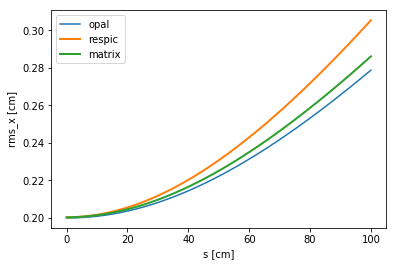

In [21]:
x_key = 's'
y_key = 'rms_x'

plt.figure()
plt.plot(data.s * 100, data.rms_x * 100.)
respic_diag.plot(x_key, y_key)
matrix_diag.plot(x_key, y_key)
plt.legend(['opal', 'respic', 'matrix'])
plt.xlabel(x_key + ' [cm]')
plt.ylabel(y_key + ' [cm]')
plt.savefig('first_benchmark.pdf')
#plt.xlim([0,40])
#plt.ylim([0,0.02])
plt.show()

In [17]:
respic_diag.get_parameter('ex_rms')[0]*10*1000

4.072579242885741